# Machine Learning Model Training and Visualization

## Overview
This notebook trains multiple machine learning models on a given dataset and evaluates their performance. The steps include:

1. **Data Preparation**: Splitting the dataset into training and testing sets.
2. **Model Training**: Implementing various regression models.
3. **Hyperparameter Tuning**: Optimizing specific models for better performance.
4. **Model Evaluation**: Computing performance metrics.
5. **Feature Importance Assessment**: Identifying the most influential features in model predictions.
6. **Visualization**: Comparing model performance through plots.


By analyzing feature importance, we gain insights into which variables contribute the most to the predictive power of our models.

### Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import shap
pd.set_option('display.max_columns', None)

/Users/leandrog/opt/anaconda3/envs/ml_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Preprocessing Data
We start preprocessing the geochemical and magnetic susceptibility datasets
for further analysis. 

The following steps include loading the susceptibility and geochemistriy datasets, merge on the sample 
and cleaning the data.

We first get the raw data and resolve `NaN` values. In this first approach we get rid of the columns with `NaN`s.

In [2]:
# This dataset contains geochemical measurements for different samples.
df_xrf_corrected = pd.read_csv('../Data/TG_xrf_corrected.csv')

# This dataset includes magnetic susceptibility measurements for the samples.
df_susc = pd.read_csv('../Data/TG_Bulk_Susceptibility_all.csv')

# We perform a left join to retain all XRF data and add susceptibility values where available.
df_all = pd.merge(df_xrf_corrected, df_susc[['sample','X_fv']], on='sample', how='left')

### Remove samples with missing susceptibility values
df_all = df_all[~df_all['X_fv'].isna()]

### Drop categorical identifiers
# The 'sample' and 'section' columns are metadata and are not needed for numerical analysis.
df_all = df_all.drop(columns = ['sample', 'section'])

### Handling Missing Data
Before performing further analysis, we check for `Nan` values in the dataframe (<LOD; below limit of detection). If any missing values exist, we replace them with 0.0

In [3]:
nan_counts = df_all.isna().sum()
print("Number of nans: ", np.sum(nan_counts))

# Fill NaNs with 0.0 and verify that no missing values remain
df = df_all.fillna(0.0)
assert np.sum(df.isna().sum()) == 0

Number of nans:  3614


### Compute Ratios


In [4]:
add_ratios = True

if add_ratios:
    
    df['Rb/Sr'] = df['Rb'] /  df['Sr']
    df['Ca/Al'] = df['Ca'] /  df['Al2O3']
    df['Fe/S']  = df['Fe'] / df['S']
    df['Si/Al'] = df['SiO2'] / df['Al2O3']
    df['K/Al']  = df['K2O'] / df['Al2O3']
    df['K/Rb']  = df['K2O'] / df['Rb']
    df['Rb/Al'] = df['Rb'] / df['Al2O3']
    df['Si/Al'] = df['SiO2'] / df['Al2O3']
    df['Ti/Al'] = df['Ti'] / df['Al2O3'] 

    # Replace nans again but now by infinity
    print("Total number of NaNs after ratios: ", np.sum(df.isna().sum()))
    df = df.replace([np.inf, -np.inf], 999)

df.head(5)

Total number of NaNs after ratios:  0


,MgO,Al2O3,SiO2,S,Cl,K2O,V,Cr,Co,Ni,Cu,Zn,Ga,As,Se,Rb,Sr,Y,Zr,Nb,Mo,Rh,Pd,Cd,Sn,Sb,Ba,La,Ce,Hf,Ta,W,Hg,Tl,Pb,Bi,Th,U,Ti,Fe,Mn,Ca,P,X_fv,Rb/Sr,Ca/Al,Fe/S,Si/Al,K/Al,K/Rb,Rb/Al,Ti/Al
0,0.355997,0.721009,1.792094,0.094367,0.333100,0.107371,0.0,0.001419,0.0,0.001008,0.005268,0.000656,0.0,0.0006,0.00045,0.000302,0.141366,0.000000,0.005311,0.00055,0.0,0.0,0.0,0.0000,0.0067,0.00360,0.00000,0.0,0.0263,0.0,0.0,0.0000,0.0,0.0,0.0020,0.0,0.00000,0.0,0.027419,0.127853,0.029152,38.297890,0.017566,1.283333e-10,0.002138,53.117064,1.354856,2.485535,0.148918,355.221846,0.000419,0.038029
1,0.509463,0.316316,0.770036,0.040300,0.196200,0.025024,0.0,0.000913,0.0,0.001049,0.001374,0.000382,0.0,0.0000,0.00050,0.000041,0.154222,0.000385,0.000000,0.00000,0.0,0.0,0.0,0.0000,0.0000,0.00000,0.00000,0.0,0.0000,0.0,0.0,0.0033,0.0,0.0,0.0022,0.0,0.00120,0.0,0.000000,0.066850,0.023049,37.894305,0.014517,9.380000e-11,0.000264,119.798828,1.658805,2.434386,0.079111,614.356931,0.000129,0.000000
2,0.981638,0.424395,1.480776,0.075350,0.291400,0.032599,0.0,0.001043,0.0,0.001066,0.001616,0.000186,0.0,0.0000,0.00040,0.000112,0.068095,0.000000,0.000000,0.00050,0.0,0.0,0.0,0.0000,0.0046,0.00375,0.00700,0.0,0.0206,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.00145,0.0,0.000000,0.110581,0.039253,39.223767,0.015431,-9.800000e-11,0.001646,92.422822,1.467567,3.489147,0.076812,290.906141,0.000264,0.000000
3,0.372074,0.347958,2.243057,0.116700,0.400067,0.047171,0.0,0.001568,0.0,0.001015,0.002339,0.000395,0.0,0.0000,0.00045,0.000136,0.125279,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0013,0.0053,0.00000,0.00000,0.0,0.0225,0.0,0.0,0.0000,0.0,0.0,0.0016,0.0,0.00000,0.0,0.000000,0.085692,0.034099,38.650576,0.014376,6.038333e-11,0.001084,111.078382,0.734294,6.446351,0.135565,347.265956,0.000390,0.000000
4,0.389912,0.104736,0.669288,0.037900,0.216333,0.035737,0.0,0.001390,0.0,0.001008,0.001340,0.000630,0.0,0.0000,0.00035,0.000017,0.119202,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0000,0.0000,0.00000,0.01215,0.0,0.0256,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.00120,0.0,0.000000,0.092975,0.030988,38.481485,0.012827,5.107333e-11,0.000142,367.414438,2.453168,6.390245,0.341208,2107.555629,0.000162,0.000000


We now separate the feature matrix ($X$) from the target data ($Y$):

In [5]:
target = 'X_fv' 

# Feature matrix
X = df.drop(columns=[target])  
feature_names = X.columns

# Response vector
Y = df[target] 

X.shape, Y.shape

((164, 51), (164,))

We rescale the response vector (multiplying by 10**10). This is not required for many ML methods, including random forrest and XGBoost, but it does not hurt to do it and we have seen this leads to better result performances. See the [issue](https://github.com/scikit-learn/scikit-learn/issues/29922#issuecomment-2460276129) in the Scikit-learn documentation for more information. 

In [6]:
X = X
Y *= 10 ** 10 

## Data Splitting: Training and Testing Sets

Before training the models, we split the dataset into **training (80%)** and **testing (20%)** subsets.
This ensures that we can evaluate model generalization on unseen data. We use `train_test_split` from `sklearn.model_selection` with a fixed random state for reproducibility.

In [7]:
# ----- Split the Data into Training and Test Sets -----
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Hyperparameter Tuning with RandomizedSearchCV

To optimize the hyperparameters of the **RandomForestRegressor**, we use **RandomizedSearchCV** with a **4-fold cross-validation (CV)** strategy.  

- The **criterion** is set to `"absolute_error"` to optimize for mean absolute error (MAE).
- The search space includes:
  - `max_depth`: Various depths (None for no limit, and values from 5 to 30 in steps of 5).
  - `min_samples_split`: Values from 2 to 8.
  - `min_samples_leaf`: Values from 2 to 8.
  - `n_estimators`: Number of trees ranging from 100 to 1000 in steps of 100.
  - `max_features`: We default this parameter since we're interested in feature importancec
- **RandomizedSearchCV** samples **10,000 different parameter combinations**, using parallel processing (`n_jobs=-1`) for efficiency.
- Since **hyperparameter tuning with 10,000 iterations** is computationally expensive, we perform the full search on a **high-performance cluster**.  
For **reproducibility and quick testing**, we use a **lighter version** with only **25 iterations** on a reduced parameter space.


In [8]:
%%time

# ----- Hyperparameter Tuning with RandomizedSearchCV -----
# Create a KFold object for 4-fold cross-validation on the training set
kf = KFold(n_splits=4, shuffle=True, random_state=42)


rf = RandomForestRegressor(criterion="absolute_error", random_state=0)

# Define a broader parameter distribution
param_dist = {
    'max_depth': [None] + list(range(5, 31, 5)), # Including None for no max depth
    'min_samples_split': list(range(2, 10,2)),         # Range from 2 to 20
    'min_samples_leaf': list(range(2, 10,2)),        # Range from 1 to 20
    'n_estimators': np.arange(100, 1001, 100)         # Range from 50 to 1000 in steps of 50
}

# Initialize the regressor with a fixed criterion and random state
rf_random = RandomForestRegressor(criterion="absolute_error", random_state=0)

# Setup RandomizedSearchCV
rf_cv = RandomizedSearchCV(rf_random,
                                   param_distributions=param_dist,
                                   n_iter=1000,      # Number of parameter settings sampled
                                   cv=kf,
                                   verbose=1,
                                   random_state=42,
                                   n_jobs=-1) 
# Fit on training data
rf_cv.fit(X_train, Y_train)

Fitting 4 folds for each of 1000 candidates, totalling 4000 fits
CPU times: user 11.8 s, sys: 1.44 s, total: 13.2 s
Wall time: 14min 42s


RandomizedSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
                   estimator=RandomForestRegressor(criterion='absolute_error',
                                                   random_state=0),
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'max_depth': [None, 5, 10, 15, 20, 25,
                                                      30],
                                        'min_samples_leaf': [2, 4, 6, 8],
                                        'min_samples_split': [2, 4, 6, 8],
                                        'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000])},
                   random_state=42, verbose=1)

In [9]:
# ----- Final Model Training -----
# Retrieve the best parameters from the search
best_params = rf_cv.best_params_
# best_params = {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': None}

print(rf_cv.best_params_)

{'n_estimators': np.int64(400), 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_depth': 10}


In [10]:
# Create and train the final model on the training data using the best parameters
model_rf = RandomForestRegressor(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    min_samples_leaf=best_params["min_samples_leaf"],
    # max_features=best_params["max_features"],
    criterion="absolute_error",
    random_state=616,
    verbose=0
)

model_rf.fit(X_train, Y_train)

RandomForestRegressor(criterion='absolute_error', max_depth=10,
                      min_samples_leaf=2, min_samples_split=8,
                      n_estimators=np.int64(400), random_state=616)

In [11]:
# ----- Evaluation on the Test Set -----
Y_pred = model_rf.predict(X_test)
rmse = mean_squared_error(Y_test, Y_pred)  # RMSE directly computed
r2 = r2_score(Y_test, Y_pred)

print(f"Test RMSE: {rmse}")
print(f"Test R² Score: {r2}")

Test RMSE: 215.6594073992556
Test R² Score: 0.5988799725740201


We can visualize the quality of the fit. 

In [12]:
y_pred_all = model_rf.predict(X_train)
y_ = model_rf.predict(X_test)

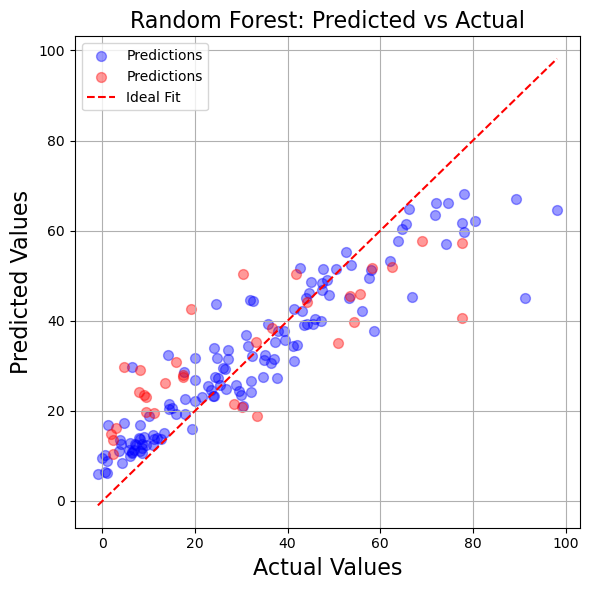

In [13]:
# # Now you can safely predict
# Plot predicted vs. actual values for the entire dataset
plt.figure(figsize=(6, 6))
plt.scatter(Y_train, y_pred_all, color='blue', alpha=0.4, s=50, label="Predictions")
plt.scatter(Y_test, y_, color='red', alpha=0.4, s=50, label="Predictions")
# Plot ideal fit line based on min and max of actual values
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], color='red', linestyle='--', label="Ideal Fit")
plt.xlabel("Actual Values", fontsize=16)
plt.ylabel("Predicted Values", fontsize=16)
plt.title("Random Forest: Predicted vs Actual", fontsize=16)
# plt.xlim(0, 100)
# plt.ylim(0, 100)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
importances = model_rf.feature_importances_
feature_names = X.columns

## Feature Importance Analysis

We extract and analyze the feature importances from the trained `RandomForestRegressor` model.  We use 3 alternative feature importance methods.
 
We store this information in a DataFrame, sort it in descending order, and print the results to identify the most influential features.

### I - Gini Index
The `feature_importances_` attribute provides the Gini importance scores, which indicate how much each feature contributes to the model's predictions. 

In [15]:
importances = model_rf.feature_importances_
feature_imp_gini = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
print(feature_imp_gini.head(10))

   Feature  Gini Importance
5      K2O         0.140899
16      Sr         0.089653
47    K/Al         0.073804
3        S         0.064853
2     SiO2         0.055399
44   Ca/Al         0.054562
40      Mn         0.051651
1    Al2O3         0.042980
15      Rb         0.033032
11      Zn         0.031821


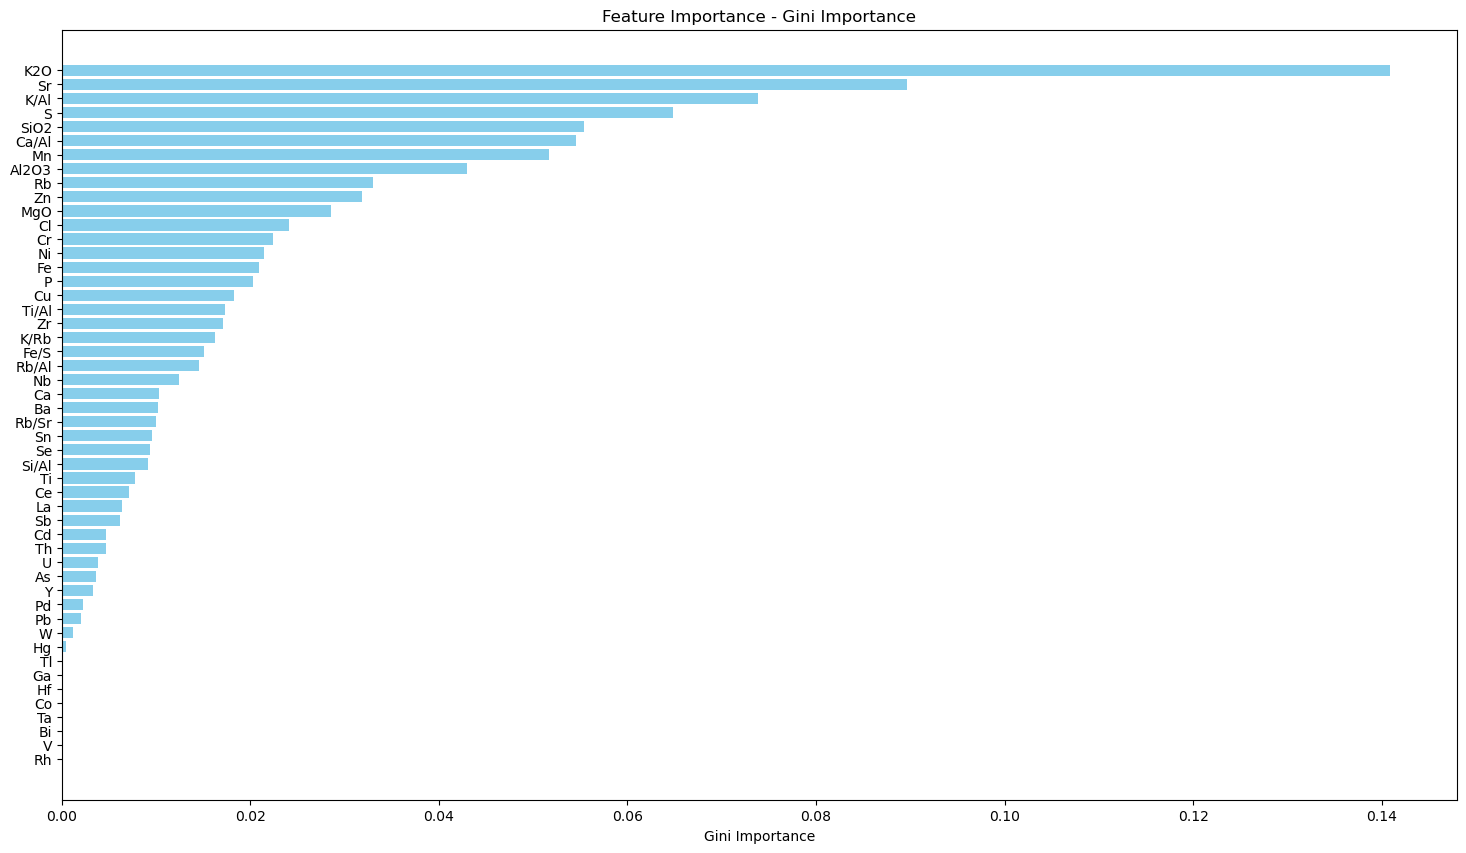

In [16]:
fig = plt.figure(figsize=(18, 10))


plt.barh(feature_imp_gini["Feature"].head(50), feature_imp_gini["Gini Importance"].head(50), color='skyblue')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

In [17]:
feature_imp_gini["Order Gini"] = np.arange(1, feature_imp_gini.shape[0]+1)
feature_imp_gini.head(5)

,Feature,Gini Importance,Order Gini
5,K2O,0.140899,1
16,Sr,0.089653,2
47,K/Al,0.073804,3
3,S,0.064853,4
2,SiO2,0.055399,5


### II - Permutation Test

we compute permutation importance for the trained `RandomForestRegressor` model.  
Permutation importance measures how much the model’s performance decreases when a feature’s values are randomly shuffled, providing an alternative view of feature importance.  
We use the `permutation_importance` function with 10 repeats (`n_repeats=10`).

In [18]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model_rf, X, Y, n_repeats=10, random_state=0, n_jobs=-1)

feature_imp_perm = pd.DataFrame({'Feature': feature_names, 'Permutation Importance': result.importances_mean}).sort_values('Permutation Importance', ascending=False)
# print(feature_imp_perm)

feature_imp_perm["Order Perm"] = np.arange(1, feature_imp_perm.shape[0]+1)
feature_imp_perm.head(7)

,Feature,Permutation Importance,Order Perm
5,K2O,0.151419,1
16,Sr,0.110217,2
44,Ca/Al,0.057988,3
3,S,0.051771,4
47,K/Al,0.046743,5
2,SiO2,0.037634,6
40,Mn,0.034581,7


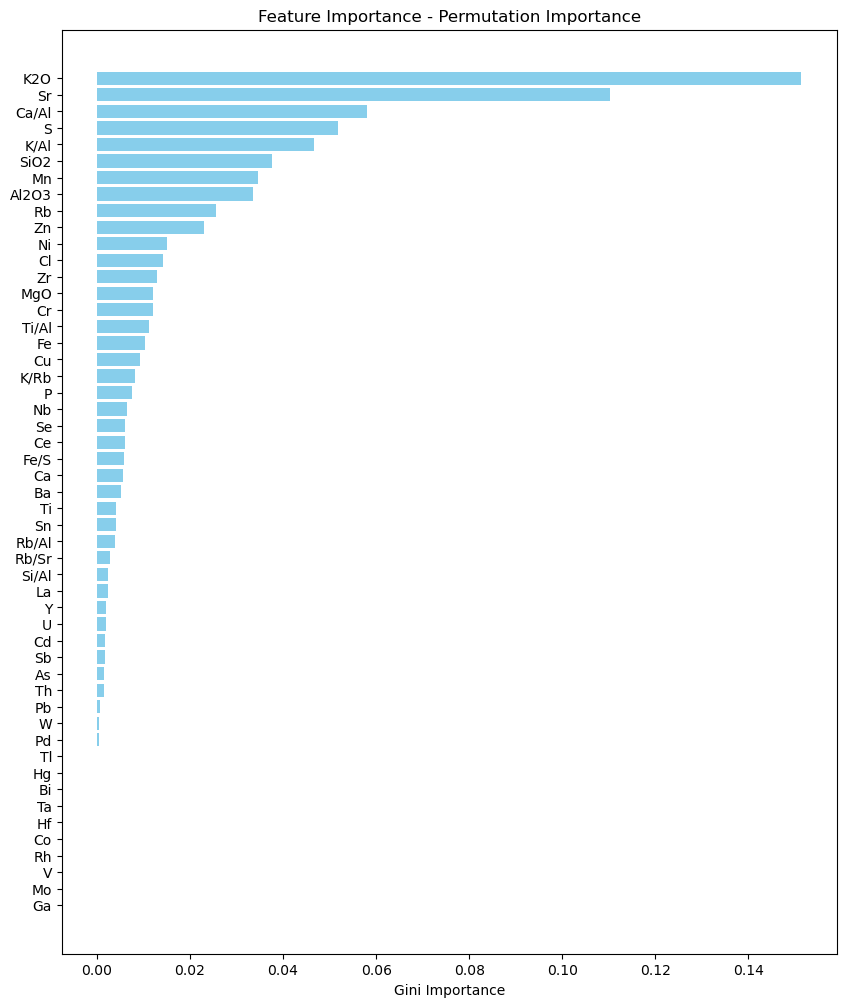

In [19]:
fig = plt.figure(figsize=(10, 12))

plt.barh(feature_imp_perm["Feature"], feature_imp_perm["Permutation Importance"], color='skyblue')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Permutation Importance')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

### III - Shapely values

This is a much better method, but we will see it gives very similar results. 

In [20]:
explainer = shap.TreeExplainer(model_rf)

In [21]:
# Calculate Shap values
choosen_instance = X.loc[[21]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. 

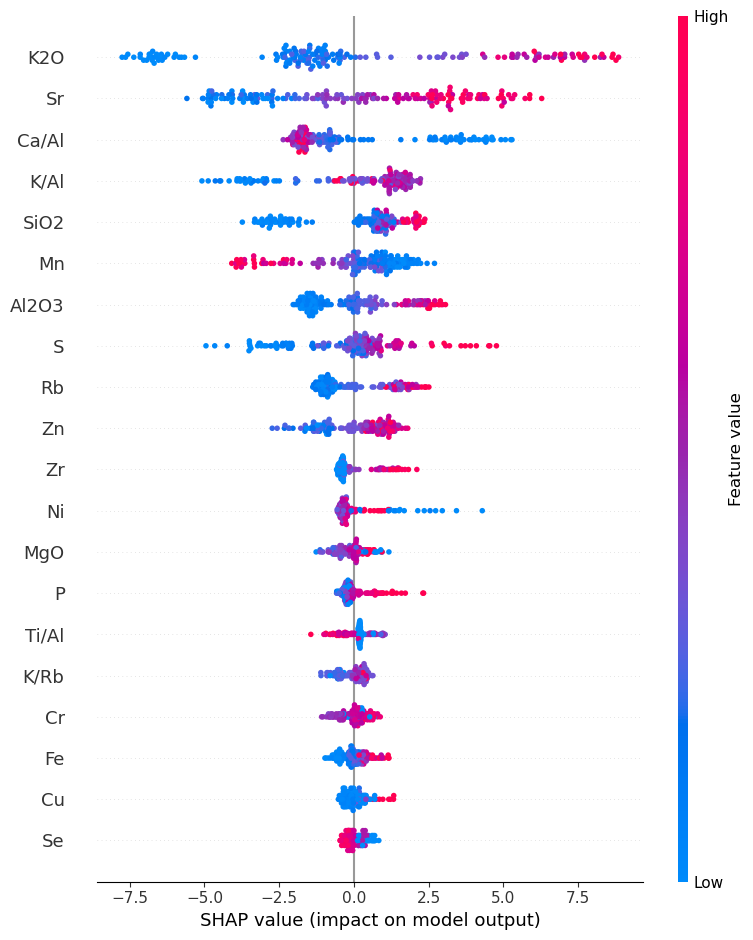

In [22]:
choosen_instance = X
shap_values = explainer.shap_values(choosen_instance)
shap.summary_plot(shap_values, X)

In [23]:
feature_order = np.array(X.columns[np.argsort(np.abs(shap_values).mean(0))])[::-1]
feature_shap = np.sort(np.abs(shap_values).mean(0))[::-1]
feature_imp_shap = pd.DataFrame({"Feature": feature_order,
                                  "Shap Value": feature_shap,
                                  "Order Shap": np.arange(1, X.shape[1]+1)})
feature_imp_shap.head()

,Feature,Shap Value,Order Shap
0,K2O,3.819325,1
1,Sr,2.853289,2
2,Ca/Al,1.927748,3
3,K/Al,1.628638,4
4,SiO2,1.488331,5


# Summary

## Figures in the paper

In [24]:
df_summary = pd.merge(feature_imp_gini, feature_imp_perm, how="inner", on="Feature")
df_summary = pd.merge(df_summary, feature_imp_shap, how="inner", on="Feature")
df_summary["Order total"] = df_summary["Order Gini"] + df_summary["Order Perm"] + df_summary["Order Shap"]
df_summary = df_summary.sort_values(by = "Order total")

In [25]:
df_short = df_summary[["Feature", "Order Gini", "Order Perm", "Order Shap"]].set_index("Feature").head(10)
df_short = df_short.rename(columns={"Order Gini": "Gini Index", "Order Perm": "Permutation Index", "Order Shap": "SHAP Value"})

In [26]:
print(df_short)

         Gini Index  Permutation Index  SHAP Value
Feature                                           
K2O               1                  1           1
Sr                2                  2           2
K/Al              3                  5           4
Ca/Al             6                  3           3
S                 4                  4           8
SiO2              5                  6           5
Mn                7                  7           6
Al2O3             8                  8           7
Rb                9                  9           9
Zn               10                 10          10


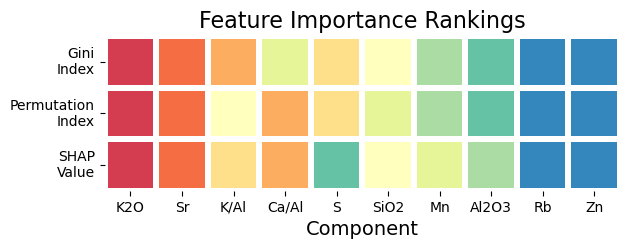

In [27]:
df_short
ax = sns.heatmap(df_short.transpose(), 
                 # annot=True, 
                 linewidth=4.0, 
                 cmap=sns.color_palette("Spectral", 9), 
                 square=True, cbar=False, annot_kws={"size":14})

ax.set_title("Feature Importance Rankings", fontsize=16)
ax.set_xlabel("Component", fontsize=14)
# ax.set_ylabel("Criteria", fontsize=14)

ax.set_yticklabels(["Gini\nIndex", "Permutation\nIndex", "SHAP\nValue"], rotation=0)

plt.tight_layout()
# plt.savefig("figures/rankings.pdf", format="pdf")

In [28]:
df_short.transpose()

Feature,K2O,Sr,K/Al,Ca/Al,S,SiO2,Mn,Al2O3,Rb,Zn
Gini Index,1,2,3,6,4,5,7,8,9,10
Permutation Index,1,2,5,3,4,6,7,8,9,10
SHAP Value,1,2,4,3,8,5,6,7,9,10


In [29]:
df_values = df_summary[["Feature", "Gini Importance", "Permutation Importance", "Shap Value"]].set_index("Feature")
df_values["Gini Importance (norm)"] = df_values["Gini Importance"] / np.sum(df_values["Gini Importance"])
df_values["Permutation Importance (norm)"] = df_values["Permutation Importance"] / np.sum(df_values["Permutation Importance"])
df_values["Shap Value (norm)"] = df_values["Shap Value"] / np.sum(df_values["Shap Value"])

df_values.head(5)

,Gini Importance,Permutation Importance,Shap Value,Gini Importance (norm),Permutation Importance (norm),Shap Value (norm)
Feature,,,,,,
K2O,0.140899,0.151419,3.819325,0.140899,0.201429,0.164113
Sr,0.089653,0.110217,2.853289,0.089653,0.146619,0.122603
K/Al,0.073804,0.046743,1.628638,0.073804,0.062180,0.069981
Ca/Al,0.054562,0.057988,1.927748,0.054562,0.077140,0.082833
S,0.064853,0.051771,1.258140,0.064853,0.068870,0.054061


In [30]:
df_values.index

Index(['K2O', 'Sr', 'K/Al', 'Ca/Al', 'S', 'SiO2', 'Mn', 'Al2O3', 'Rb', 'Zn',
       'Ni', 'MgO', 'Zr', 'Cl', 'Cr', 'Ti/Al', 'Fe', 'P', 'Cu', 'K/Rb', 'Nb',
       'Se', 'Fe/S', 'Rb/Al', 'Ca', 'Ba', 'Ce', 'Rb/Sr', 'Ti', 'Sn', 'La',
       'Si/Al', 'Sb', 'Cd', 'U', 'As', 'Th', 'Y', 'Pb', 'Pd', 'W', 'Hg', 'Tl',
       'Co', 'Ga', 'Hf', 'Ta', 'Bi', 'V', 'Rh', 'Mo'],
      dtype='object', name='Feature')

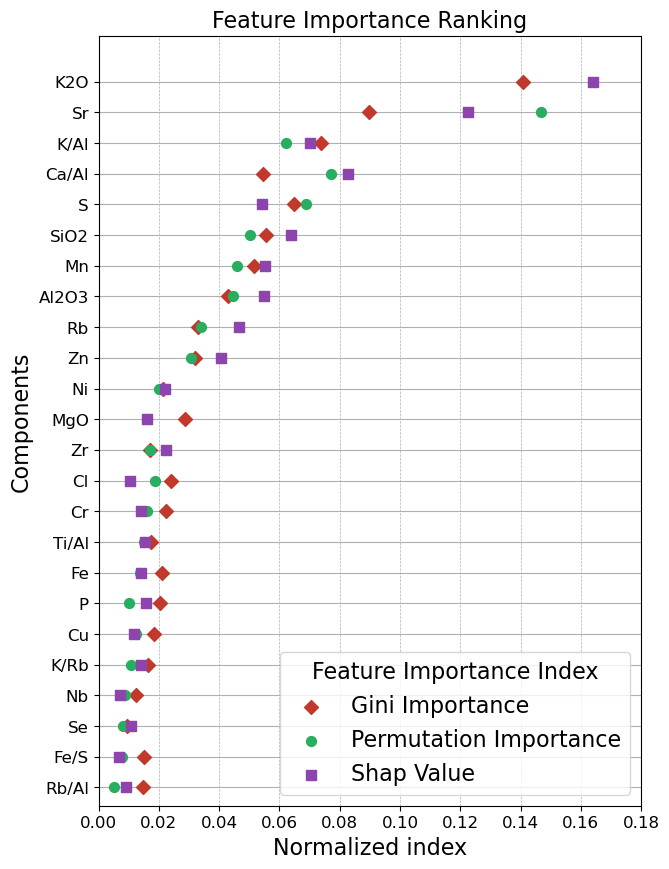

In [31]:
fig, ax_ranking = plt.subplots(figsize=(7,10))

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

plt.grid(axis = 'x', linestyle = '--', linewidth = 0.5)
plt.grid(axis = 'y')

plt.scatter(df_values["Gini Importance (norm)"], np.arange(df_values.shape[0]+1, 1, -1), label="Gini Importance", marker="D", c="#c0392b", s=50, zorder = 100)
plt.scatter(df_values["Permutation Importance (norm)"], np.arange(df_values.shape[0]+1, 1, -1), label="Permutation Importance", marker="o", c="#27ae60", s=50, zorder = 100)
plt.scatter(df_values["Shap Value (norm)"], np.arange(df_values.shape[0]+1, 1, -1), label="Shap Value", marker="s", c="#8e44ad", s=50, zorder = 100)

plt.xlabel("Normalized index", fontsize=16)
plt.ylabel("Components", fontsize=16)
ax_ranking.set_yticks(np.arange(df_values.shape[0]+1, 1, -1), df_values.index)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlim(0,0.18)
plt.ylim(28.4, 53.5)
plt.title("Feature Importance Ranking", fontsize=16)

leg = plt.legend(title="Feature Importance Index", loc="lower right", fontsize=16, title_fontsize=16)

# plt.savefig("figures/importance.pdf", format="pdf")